In [14]:
import sys
sys.path.append('..')

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from common.time_layers import * 
from common.np import *
from common.base_model import BaseModel
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
# from rnnlm import Rnnlm
# from better_rnnlm import BetterRnnlm

# 6 게이트가 추가된 RNN

RNN은 성능이 좋지 못하다. 그 이유는 대부분 멀리 떨어진 long term 의존관계를 잘 학습 못한다는 점에 있다. 

그래서 보통 RNN이라 하면 vanilla RNN이 아닌 LSTM이나 GRU를 의미한다. 

LSTM, GRU에는 gate라는 구조가 더해져 long term 의존관계 문제를 해결한다. 

## 6.1 RNN의 문제점

BPTT에서는 기울기 소실 또는 기울기 폭발이 일어난다. 

### 6.1.1 RNN 복습

### 6.1.2 기울기 소실 또는 기울기 폭발

Tom was watching TV in his room. Mary came into the room. Mary said hi to ____

Tom까지 한참을 거슬러 올라가야 한다. 기울기가 소실되거나 폭발한다. 

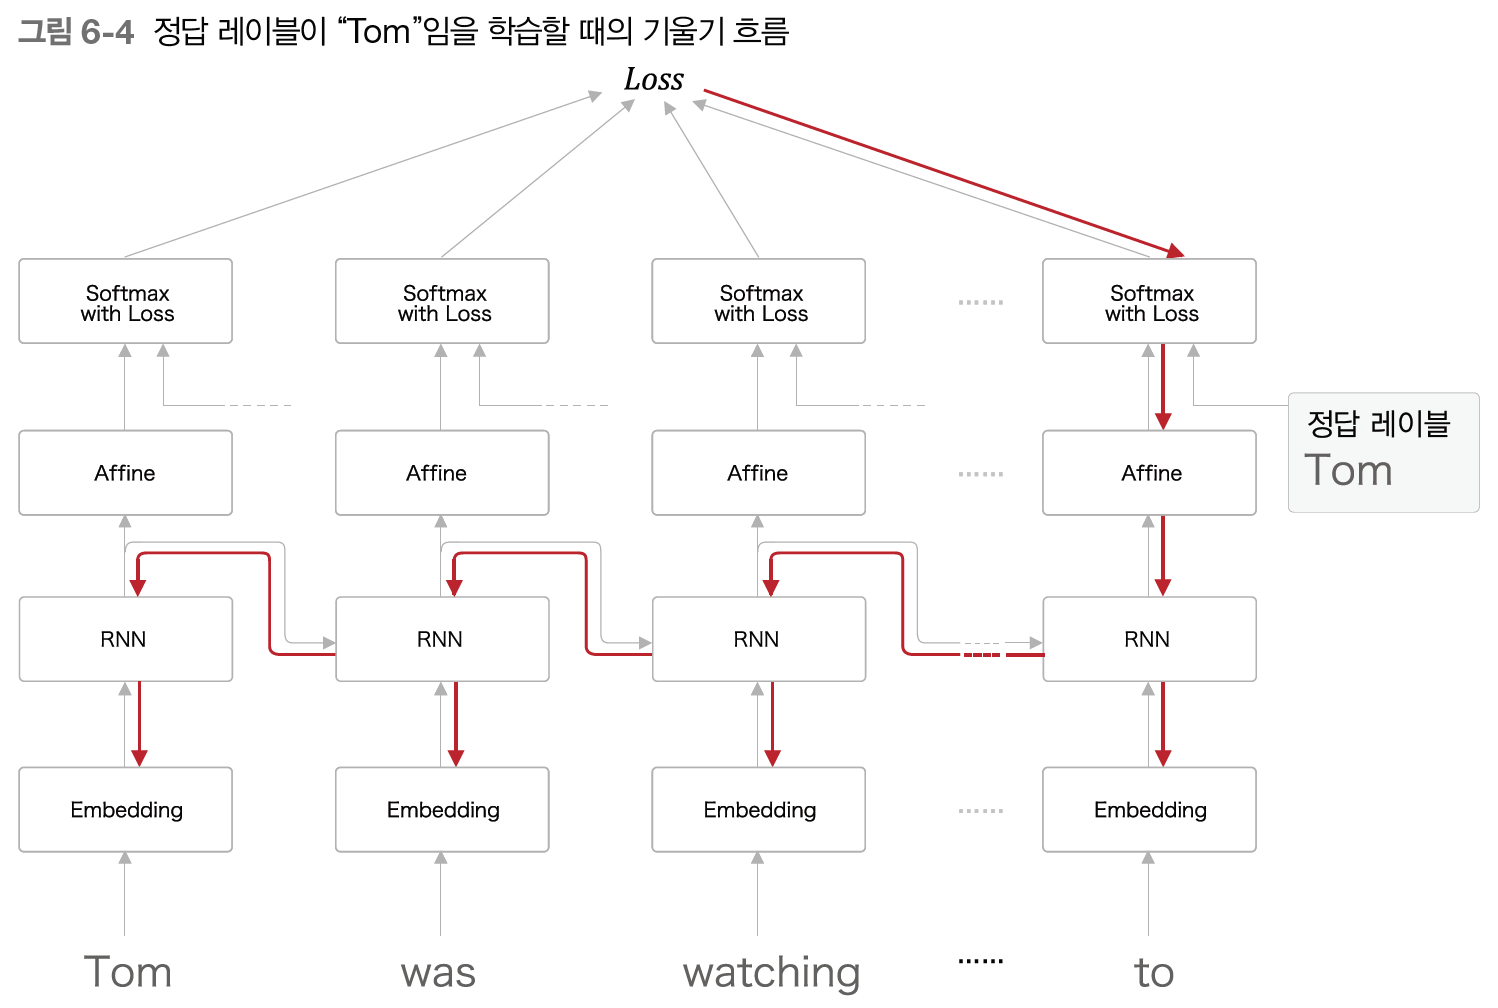

### 6.1.3 기울기 소실과 기울기 폭발의 원인

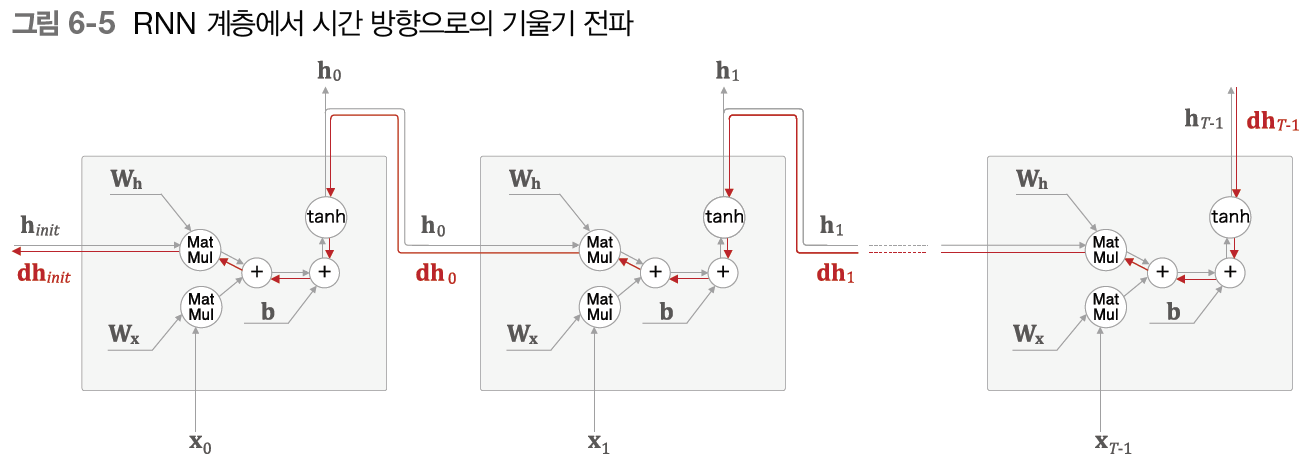

`+` 노드에서는 문제 없지만, `tanh`와 `matmul` 노드에서 기울기 소실이 일어난다. 

1.  우선 `tanh`를 미분하면 `1-y^2`이 된다. 이것을 데이터 사이즈만큼 반복하게 된다. 
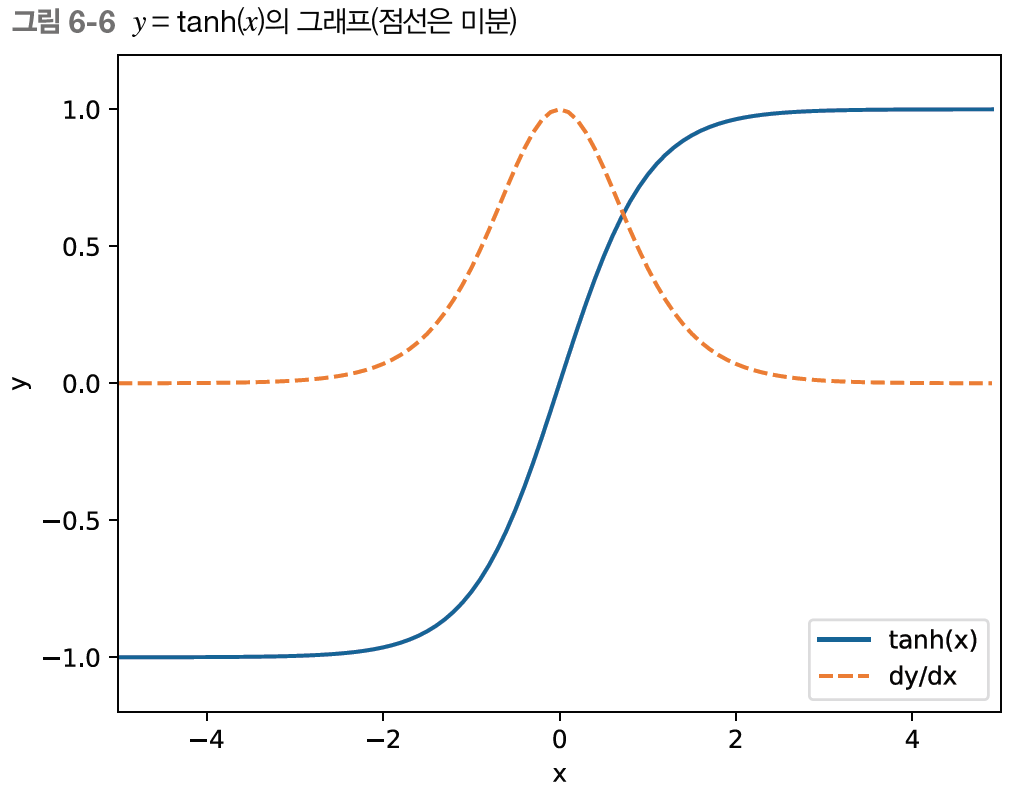

2. `matmul`는 `dh`가 상류에서 내려오면 `dh * Wh`으로 기울기를 계산한다. 이것을 데이터 사이즈만큼 반복하게 된다. 

In [5]:
N = 3 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3) # 재현 가능하도록 난수의 seed를 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N # 미니배치 N개의 평균 L2 norm = dh의 크기
    norm_list.append(norm)

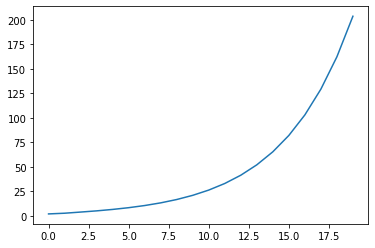

In [6]:
plt.plot(norm_list)

기울기 폭발이 일어난다. (exploding gradients) 

결국 overflow를 일으킬 수 있다. 

그러니 이번에는 `Wh` 초기값을 바꿔 진행해보자. 

In [7]:
N = 3 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3) # 재현 가능하도록 난수의 seed를 고정

###
Wh = np.random.randn(H, H) * 0.5 # 변경
###

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N # 미니배치 N개의 평균 L2 norm = dh의 크기
    norm_list.append(norm)

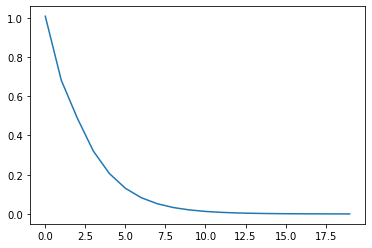

In [8]:
plt.plot(norm_list)

이번엔 기울기 소실이 발생한다. (vanishing gradients) 

기울기가 지수적으로 증가하거나 지수적으로 소실되는 것을 확인했는데, 그 이유는 `Wh`를 `T`번 반복해서 곱했기 때문이다. 

스칼라의 경우 1보다 크냐/작냐가 증/감의 기준이 되고, 행렬의 경우 특이값(중 최대값)이 1보다 크냐/작냐에 따라 증/감이 결정된다. - 사실 결정된다. 라고 말할 순 없다. 특이값이 1보다 크냐/작냐에 따라 증/감할 가능성이 달라지는 것 뿐이다. 행렬에선 무조건 기울기 폭발/소실 되는건 아니다. 

### 6.1.4 기울기 폭발 대책

gradient clipping을 이용한다. 

pseudo-code로 작성하면, 

```python
if ||g_hat|| >= threshold:
    g_hat = g_hat * (threshold / ||g_hat||)
```
- `g_hat`: 신경망에서 사용되는 모든 매개변수의 기울기를 하나로 모은 것. 
- `||x||`: L2 norm을 나타낸다. 

즉, 전체 기울기의 L2 norm이 일정 `threshold`를 넘으면 기울기를 1보다 작은 `(threshold / ||g_hat||)`만큼 곱해줘 더 작게 만들어 update

In [9]:
dW1 = np.random.randn(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0 # threshold

def clip_grads(grads, max_norm):
    total_norm = 0 # g_hat == sum of all grads. 
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-8)
    if rate < 1:
        for grad in grads:
            grad *= rate

## 6.2 기울기 소실과 LSTM

RNN의 아키텍쳐(신경망 구조)를 아예 바꿔야 한다. 게이트가 추가된 RNN인 LSTM을 여기서 소개한다. 

GRU는 부록.C에서 소개한다. 

### 6.2.1 LSTM의 인터페이스

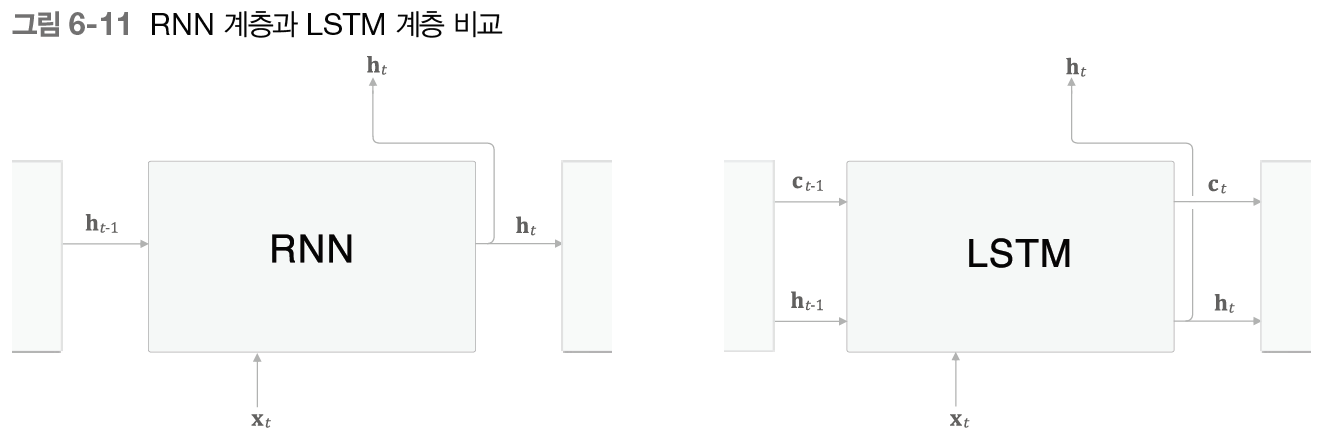

LSTM에 추가된 `c`를 memory cell(또는 그냥 cell)이라고 하며, 기억 메커니즘을 담당한다.

cell은 데이터를 자기 자신(LSTM계층)으로만 주고받고(=옆으로) 다른 계층으로는 출력하지 않는다. 

은닉상태 `h`는 이전과 마찬가지로 다른계층(=위쪽)으로 출력된다. 

### 6.2.2 LSTM 계층 조립하기

기억 cell `c_t`에는 과거~t까지의 모든 정보가 저장되어 있도록 만든다. 

이 `c_t`를 tanh함수에 넣어 `h_t`를 만들어 윗 계층 및 옆 LSTM에 feed한다. 즉, `h_t = tanh(c_t)`

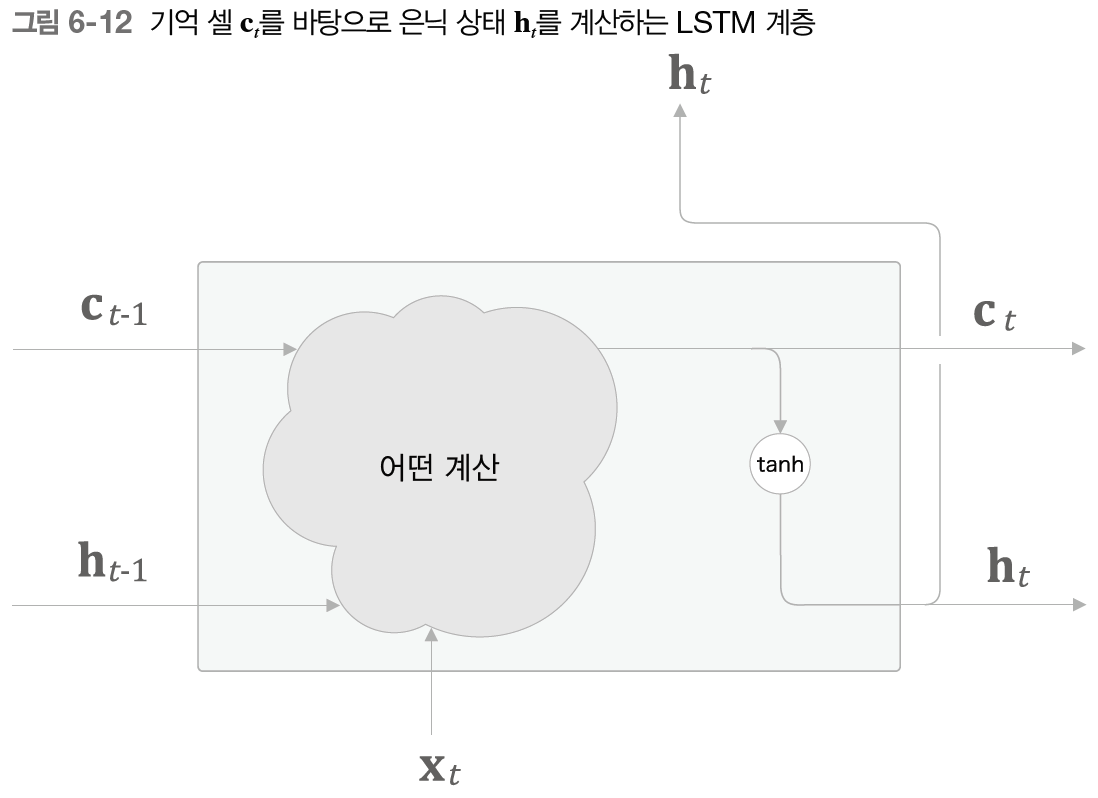

이제 gate의 개념에 대해 설명하겠다. gate는 데이터의 흐름을 조절한다. 

열림 상태의 범위 0.0 ~ 1.0 사이의 값을 통해 얼마나 흘려보낼지 결정할 수 있다. 이 열린 범위 또한 학습되는 parameter이다. 

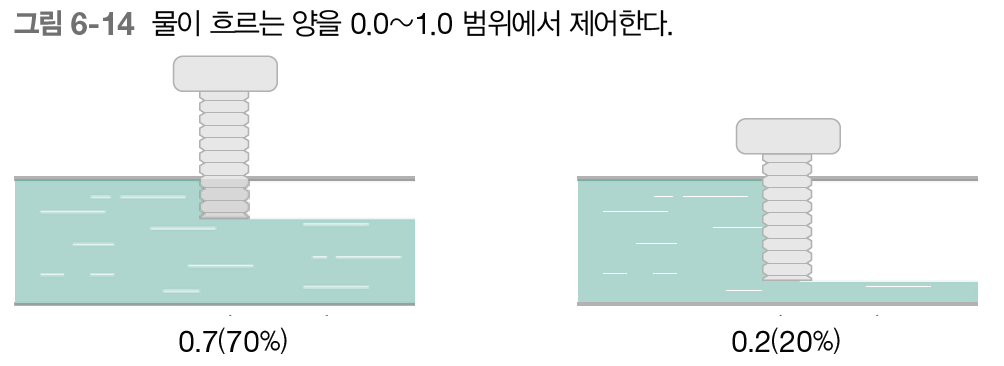

### 6.2.3 output 게이트

t시점에서 출력할 때 `h_t = tanh(c_t)`가 다음 시각 t+1에 얼마나 중요한가? 를 조정하기 위해 게이트를 사용한다. 은닉상태 `h_t`의 출력을 담당하는 gate이므로 "output gate"라고 부른다. 

output gate의 열림 상태(몇 %나 흘릴까)는 입력 데이터 `xt`와 이전 은닉상태 `h_t-1`로부터 구한다. 

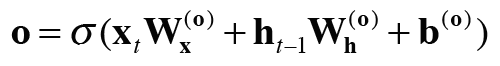

- o 첨자는 output을 뜻한다. 
- σ는 시그모이드 함수이다. (출력범위: 0.0 ~ 1.0) 데이터를 얼마나 통과시킬지 정하는 비율이라고 해석할 수 있다. 
- `x_t`와 `h_t-1`은 행벡터이다. 

이렇게 구한 `o`를 `tanh(c_t)`와 아다마르 곱해 `h_t`로 출력한다. 

tanh의 출력범위: -1.0 ~ 1.0

이 출력은 인코딩된 정보의 강약(정도)를 표현한다고 해석할 수 있다. 

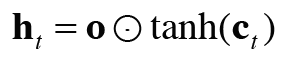

아다마르 곱(Hadamard product)란 element-wise한 곱이며, 기호로는 ⊙로 나타낸다. 

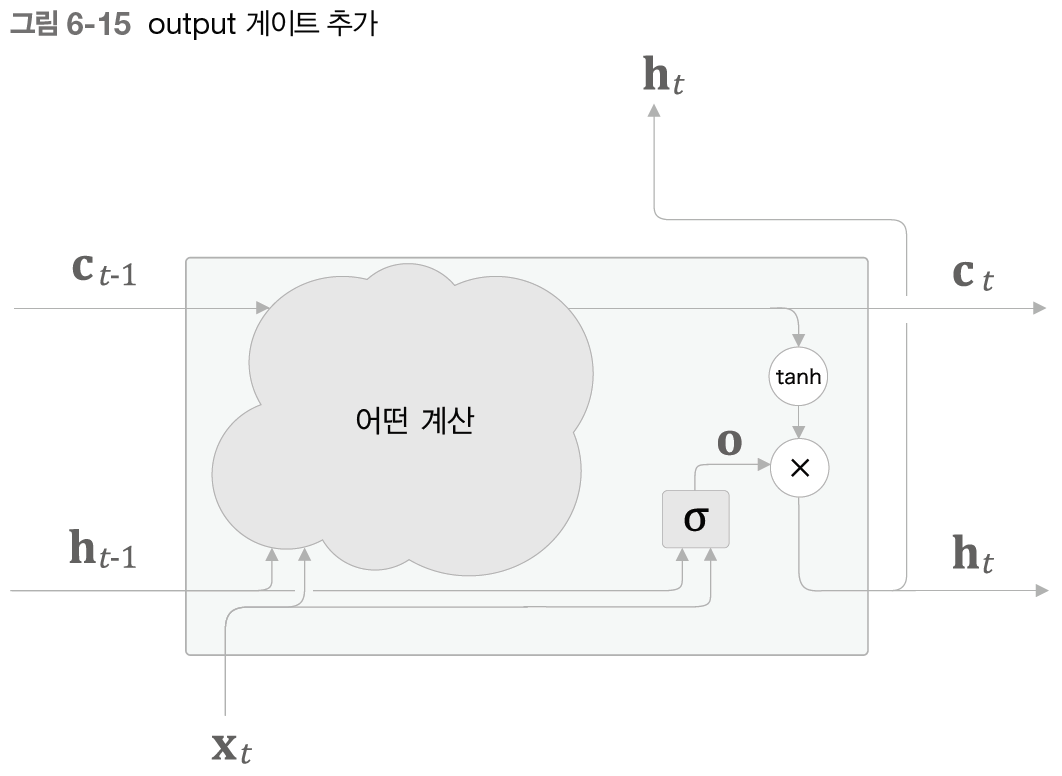



### 6.2.4 forget 게이트

망각은 더 나은 전진을 낳는다. 

`c`, cell에 무엇을 잊을 것인지 명확히 지시해야 한다. 

`c_t-1`의 기억 중 불필요한 기억을 잃게 해주는 게이트가 forget gate이다. 이를 LSTM 계층에 추가하면, 

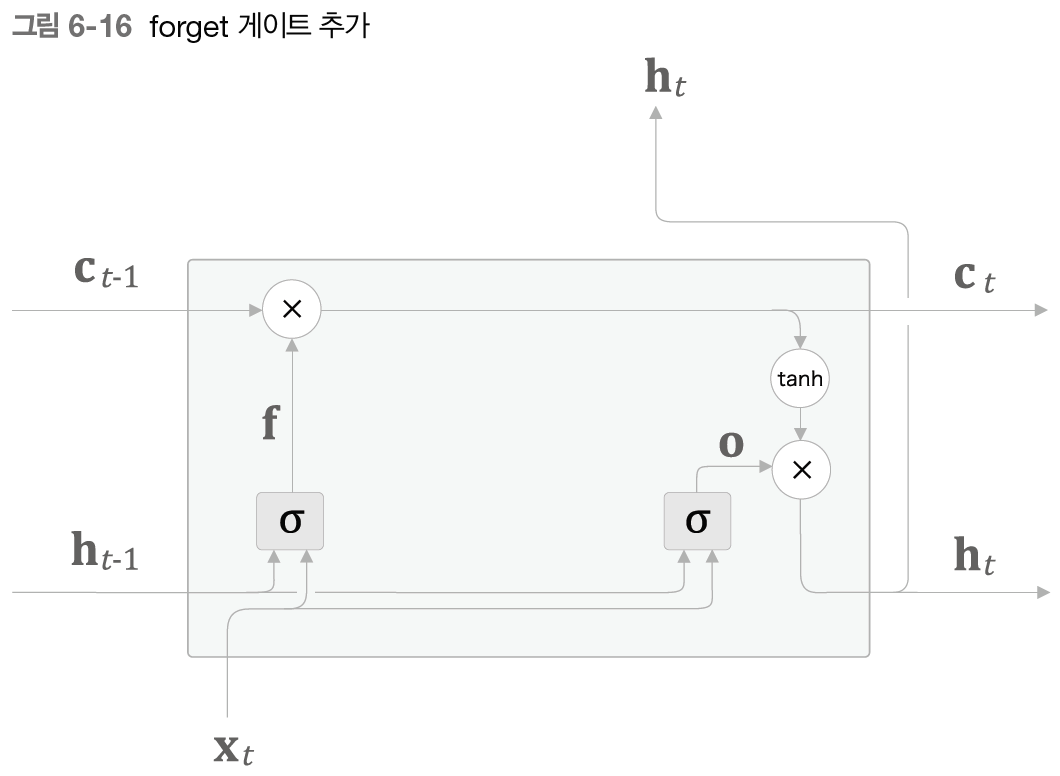

`f`를 구하는 것도 `o`를 구했던 것과 똑같다. 

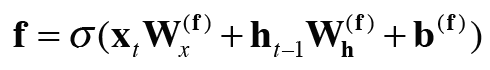

하지만 이 `f`는 `h`를 구하는 것이 아니라 `c_t-1`에 곱해져 `c_t`를 구한다. 

즉, `c_t 에는 f ⊙ c_t-1`이 더해진다. (다른 것이랑 같이 더해짐. 6.3 참고) 

### 6.2.5 새로운 기억 셀

그런데 forget gate를 쓰면 잊어야 할 기억만 삭제한 것이니까 이제 무엇을 기억해야 하는지도 알려줘야 한다. 

tanh노드가 계산한 결과 `g`가 기억 cell `c_t-1`에 더해진다. 기억에 새 '정보'가 추가된 것이다. 

이건 출력을 조절하는 게이트가 아니라 '정보'를 추가하는 것이 목적이기 때문에 sigmoid가 아닌 tanh를 쓰는 것이다. 

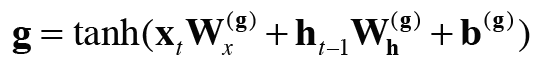

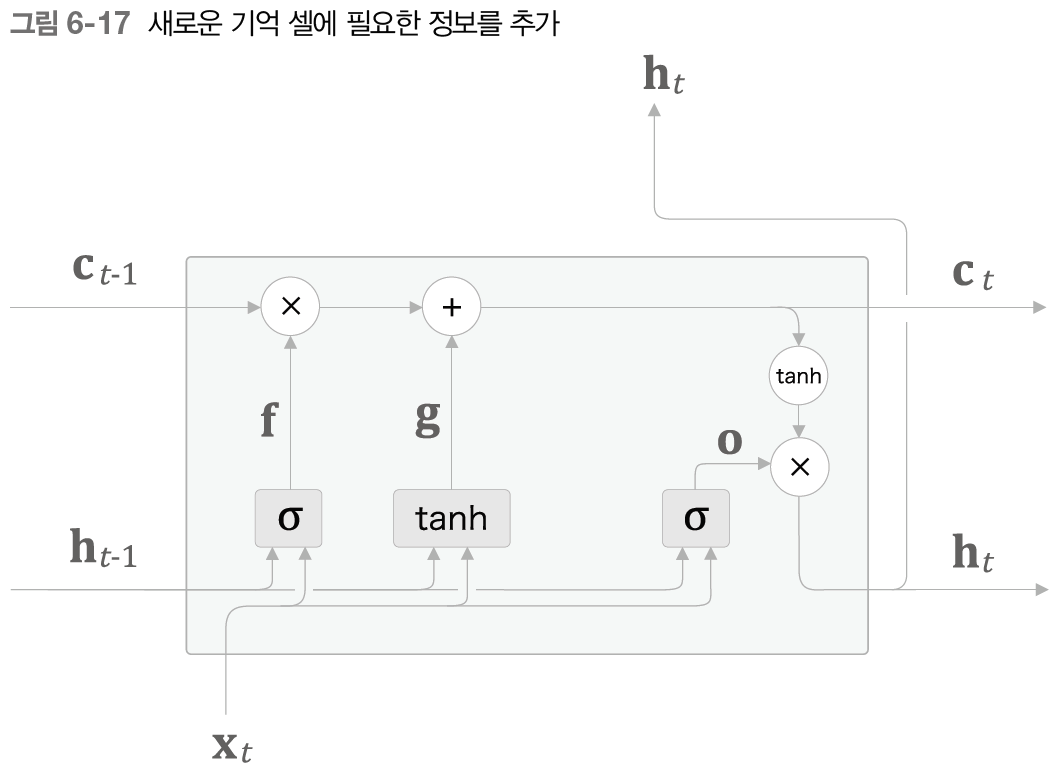

### 6.2.6 input 게이트

마지막으로, 새로 추가하는 정보 `g` 또한 게이트를 거치게 해준다. 이 게이트를 input gate라고 한다. 

이 게이트는 `g`의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지 판단한다. 새 정보를 그냥 수용하는 것이 아닌 최적화되도록 적당량 받아내는 것이 이 게이트의 역할이다. 

input gate의 출력 `i`역시 똑같이 계산된다. 

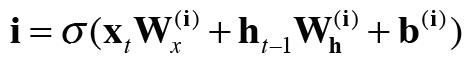

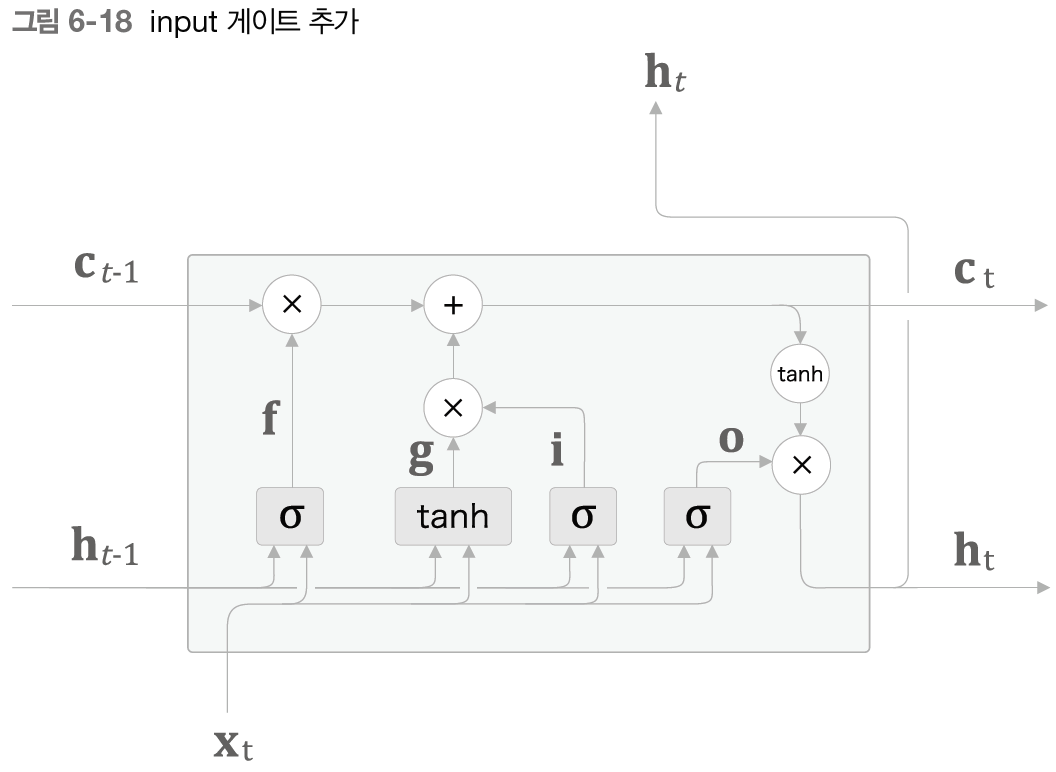

이것이 기본적인 LSTM의 게이트 구조이고, variation에 따라 게이트 구조가 다른 것들도 많다. 

### 6.2.7 LSTM의 기울기 흐름

하지만 정확히 어떤 원리로 기울기 소실을 해결해 주는 것일까?

기억 cell `c`의 역전파에 주목하자. 

`+`노드는 기울기를 그대로 흘린다. 영향 없다. `*`노드는 아다마르 곱, 즉 element-wise 곱을 수행한다. 아까는 `MatMul`곱을 쓴 것과 다르다. 

또한 매 시간 다른 게이트 값을 이용해 원소별 곱을 계산한다. 계속 새로운 게이트 값을 쓰므로, 곱셈의 효과가 단순히 누적되지 않는다. 

그래서 기울기 소실이 일어나기 어렵다. 

`*`노드는 forget 게이트가 제어하는데, 잊어야 성능 좋아지는 cell의 원소는 기울기를 작게 만들고 기억해야 성능이 좋아지는 cell의 원소는 기울기를 유지시켜 흘려보내기 때문에 이런 효과가 나타난다고 생각할 수 있다. 

LSTM (Long Short-Term Memory)는 단기기억을 길게 지속하는 것을 의미한다. 

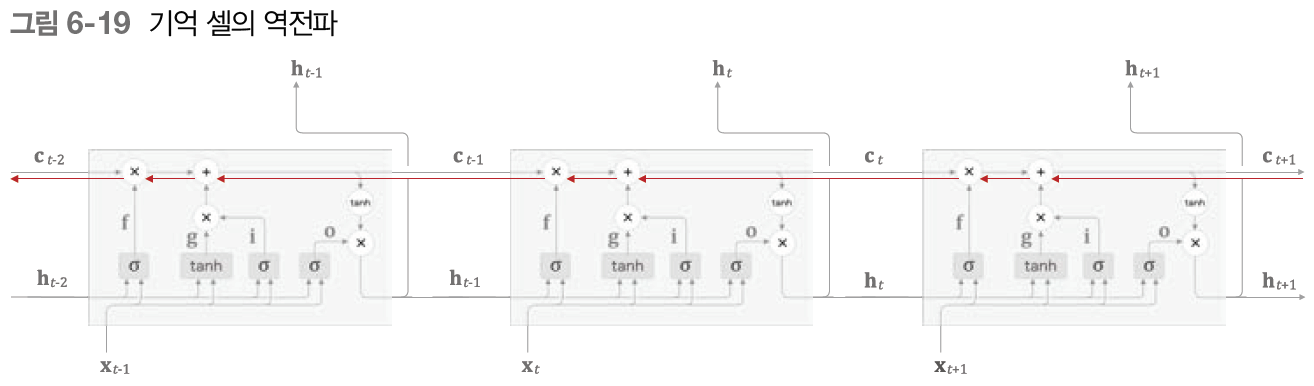



<h2 style='color:red;'>이 말은 기울기를 계속해서 W^n 하는 것과 다르다는 뜻인데, 그럼 중간에 어떨땐 1을 곱해주고 어떨 땐 1보다 작은 값을 곱해주고 그런다는 뜻인가? </h2>

## 6.3 LSTM 구현

수식 총정리

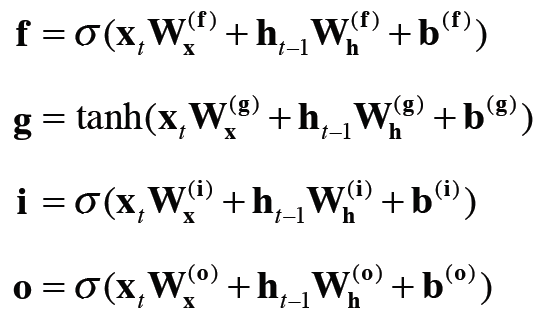

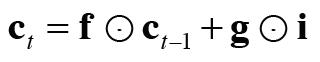

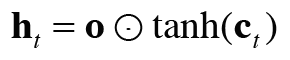

네 수식은 모두 affine transformation이 되어있다. 

Affine transformation이란 행렬 변환과 평행이동(편향)을 결합한 형태 - 즉, `x*W_x + h*W_h + b` 형태의 식을 가리킨다. 

이 affine transformation을 하나의 식으로 한 번에 계산할 수 있다. 그러면 코드도 간결해지고 계산도 빨라진다. (대행렬 연산이므로)

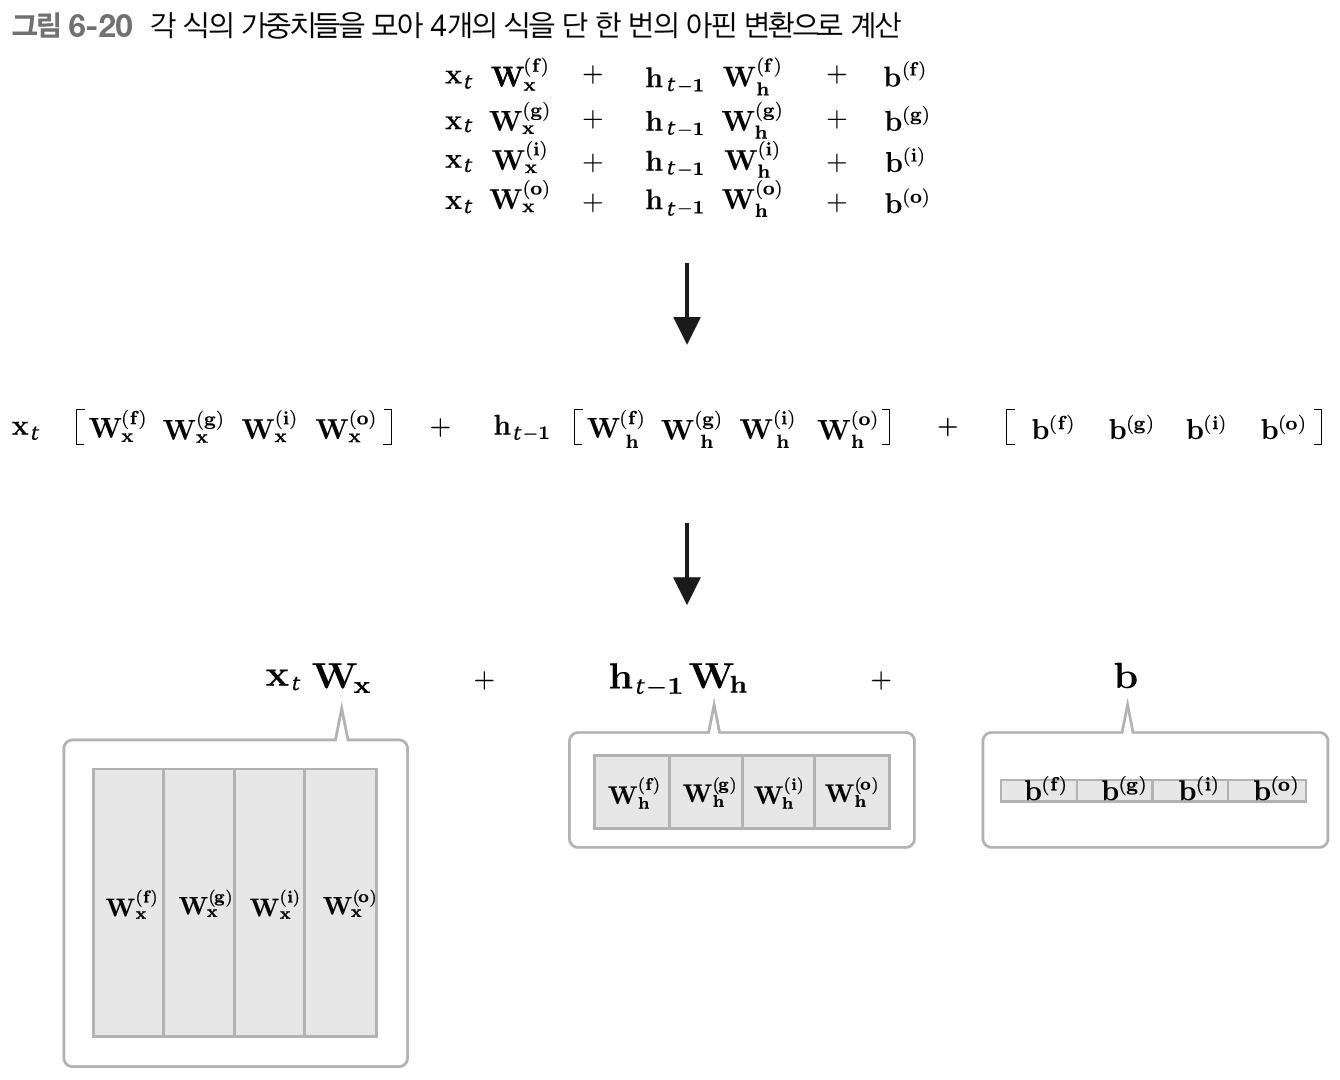

뒤의 구현을 위해 형상을 표현해보면, 

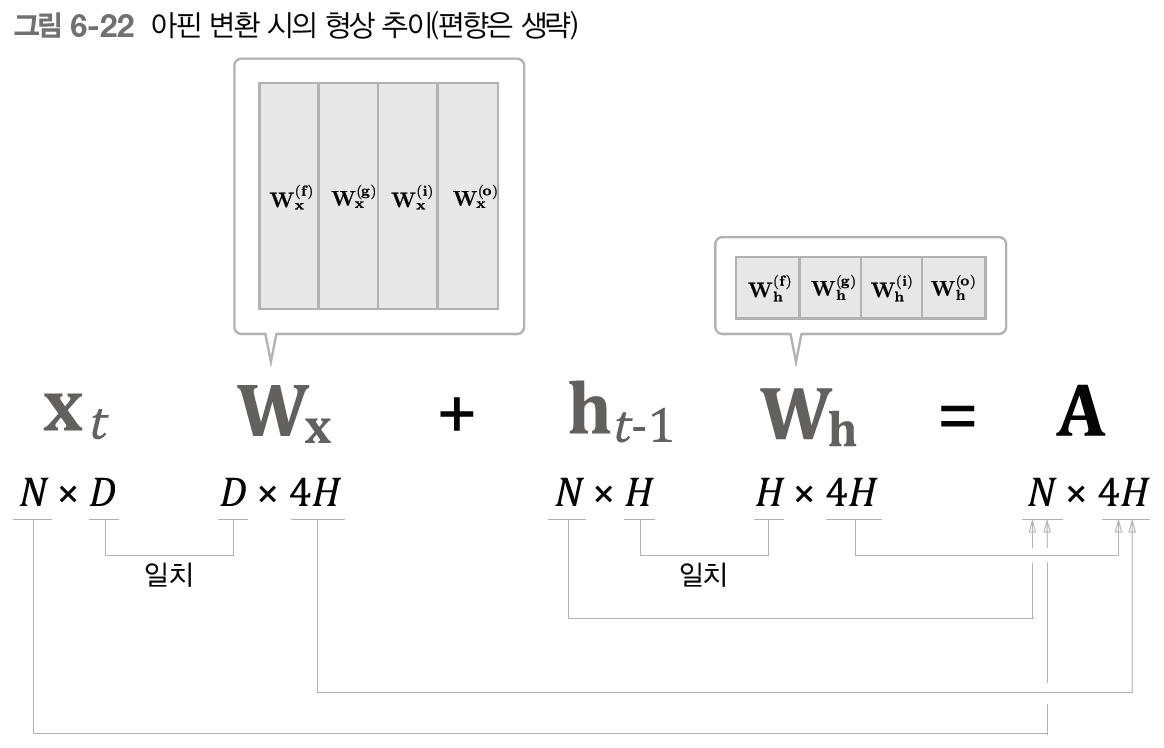

이렇게 한꺼번에 연산하는 것을 계산그래프로 그리면

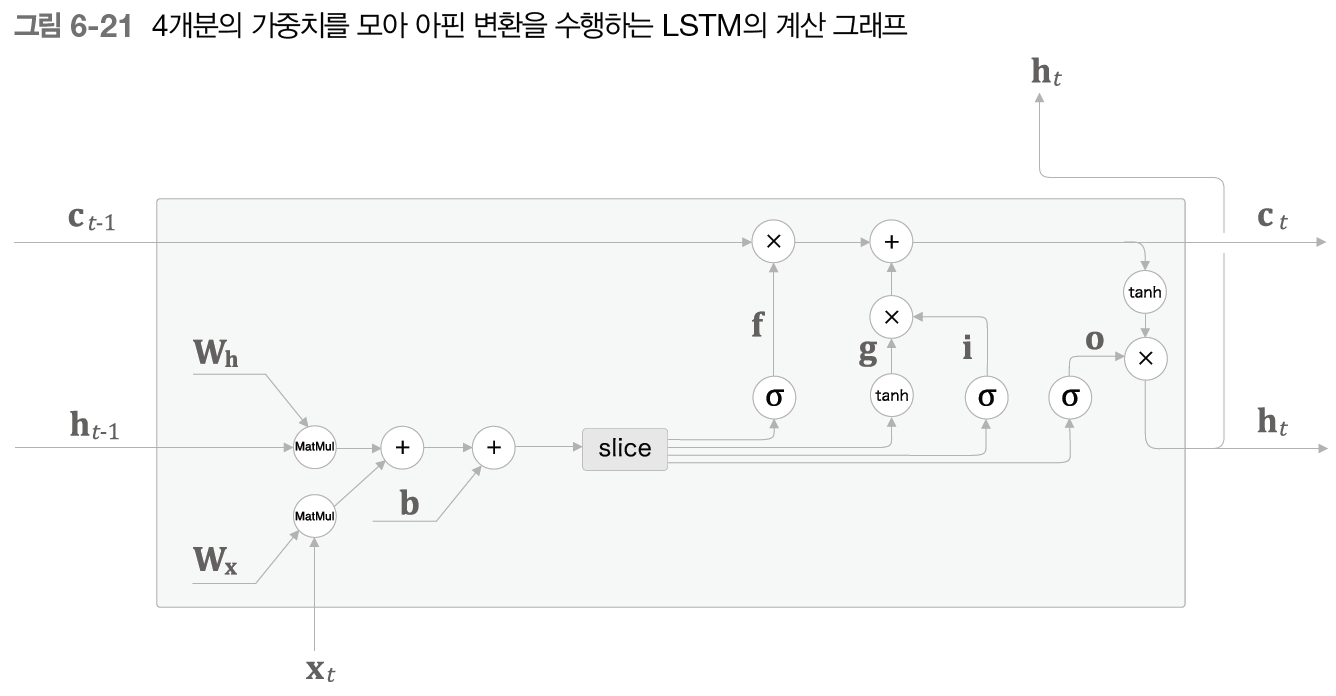

In [11]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b] # Wx에는 Wx_f, Wx_g, Wx_i, Wx_o가 모두 들어있다. Wh도 마찬가지. 
                                    #즉, 표면적으로는 RNN과 같이 Wx, Wh, b 세 개의 parameter만 input하지만 살펴보면 내부의 형상이 다른 것이다. 
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None # 순전파 결과를 보관했다가 역전파때 사용. 
    
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        # Slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    

중간의 slice를 list slice로 시행해 주었는데, 이 부분도 원래 노드로 표현되고 순전파와 역전파시의 방법은 다음과 같다. 

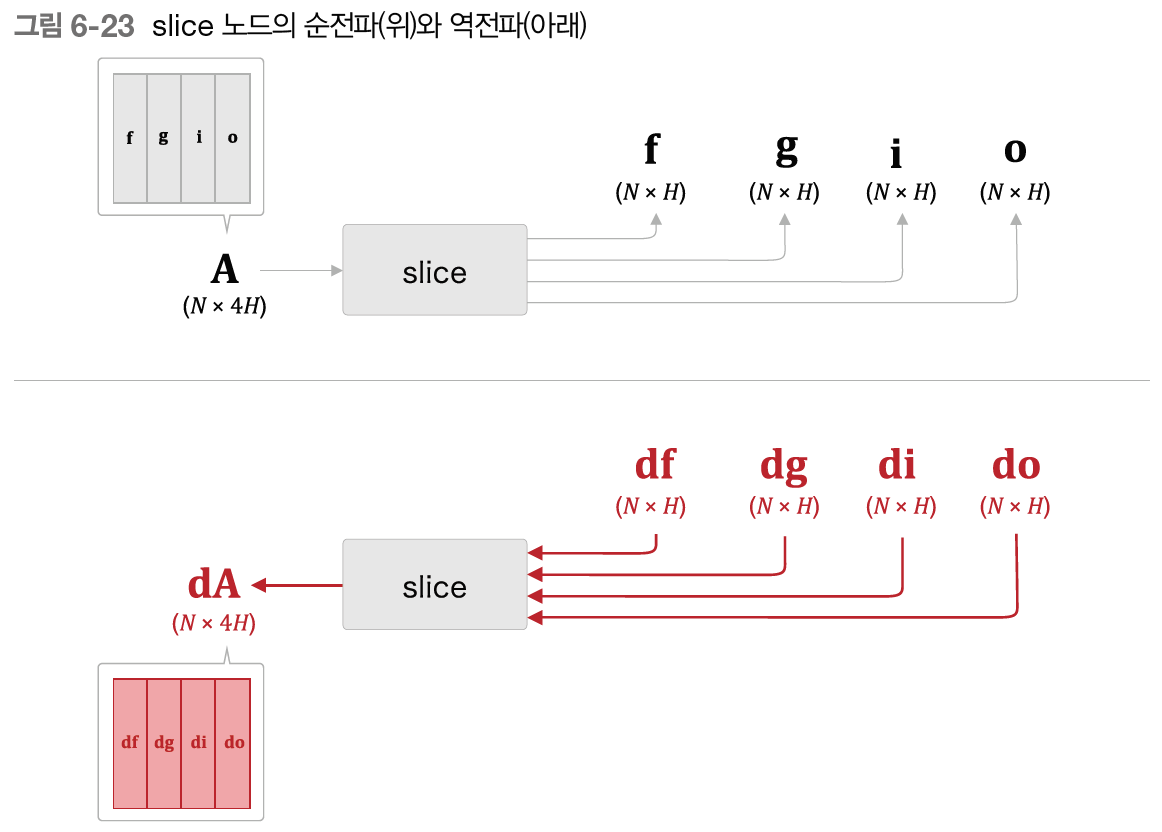

역전파시 `df`, `dg`, `di`, `do`를 horizontal하게 이어붙여 `dA`를 만드는데, `np.hstack()`을 이용하면 된다. 
```python
dA = np.hstack((df, dg, di, do))
```


### 6.3.1 Time LSTM 구현

앞의 Time RNN과 마찬가지로, Time LSTM은 `T`개의 시계열 데이터를 (=그리고 그 수 만큼의 LSTM계층을) 한 번에 처리하는 계층이다. 

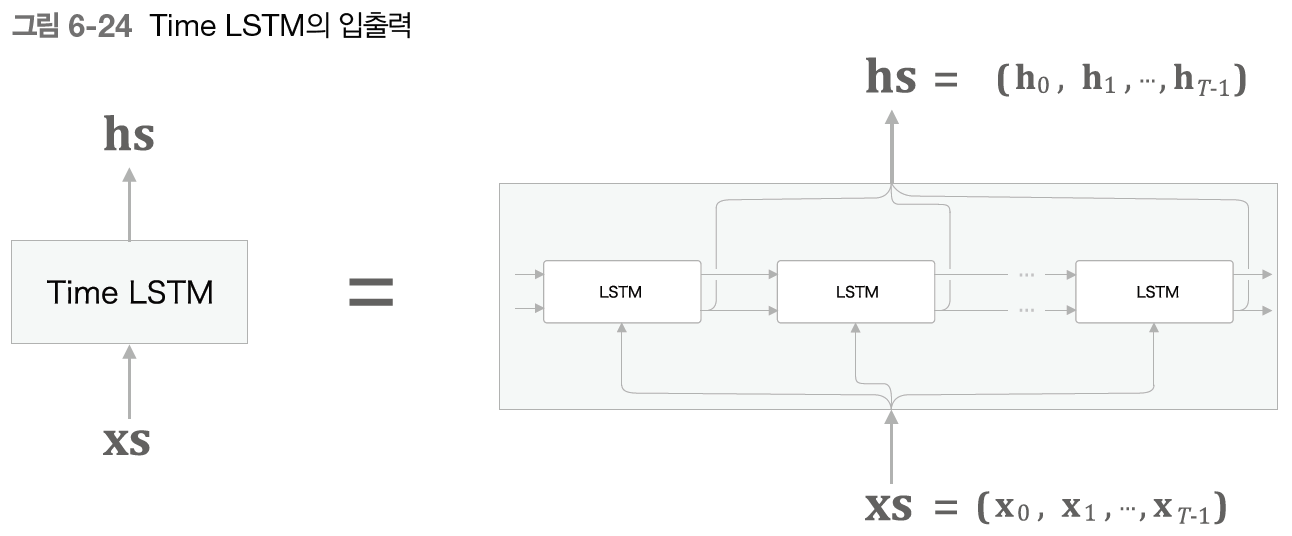

앞의 Truncated BPTT에서 역전파의 연결을 적당한 길이로 끊었었다. 이와 같이 은닉상태 `h`와 기억 cell `c`를 인스턴스 변수로 유지해 블록 사이에 계속 값을 들고있을 수 있도록 한다. 

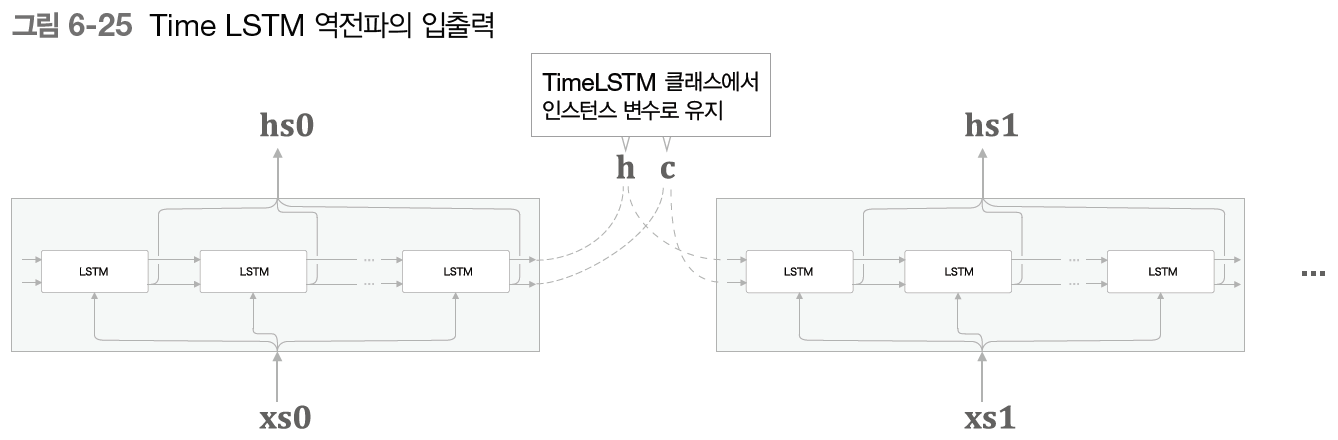

In [12]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
        
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
        
        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c
    
    def reset_state(self):
        self.h, self.c = None, None

## 6.4 LSTM을 사용한 언어 모델

Time RNN을 Time LSTM으로 바꾼 것이 다다. 

앞에서 `SimpleRnnlm`클래스를 만들었고, 이제 `Rnnlm`클래스를 만들 것이다. 

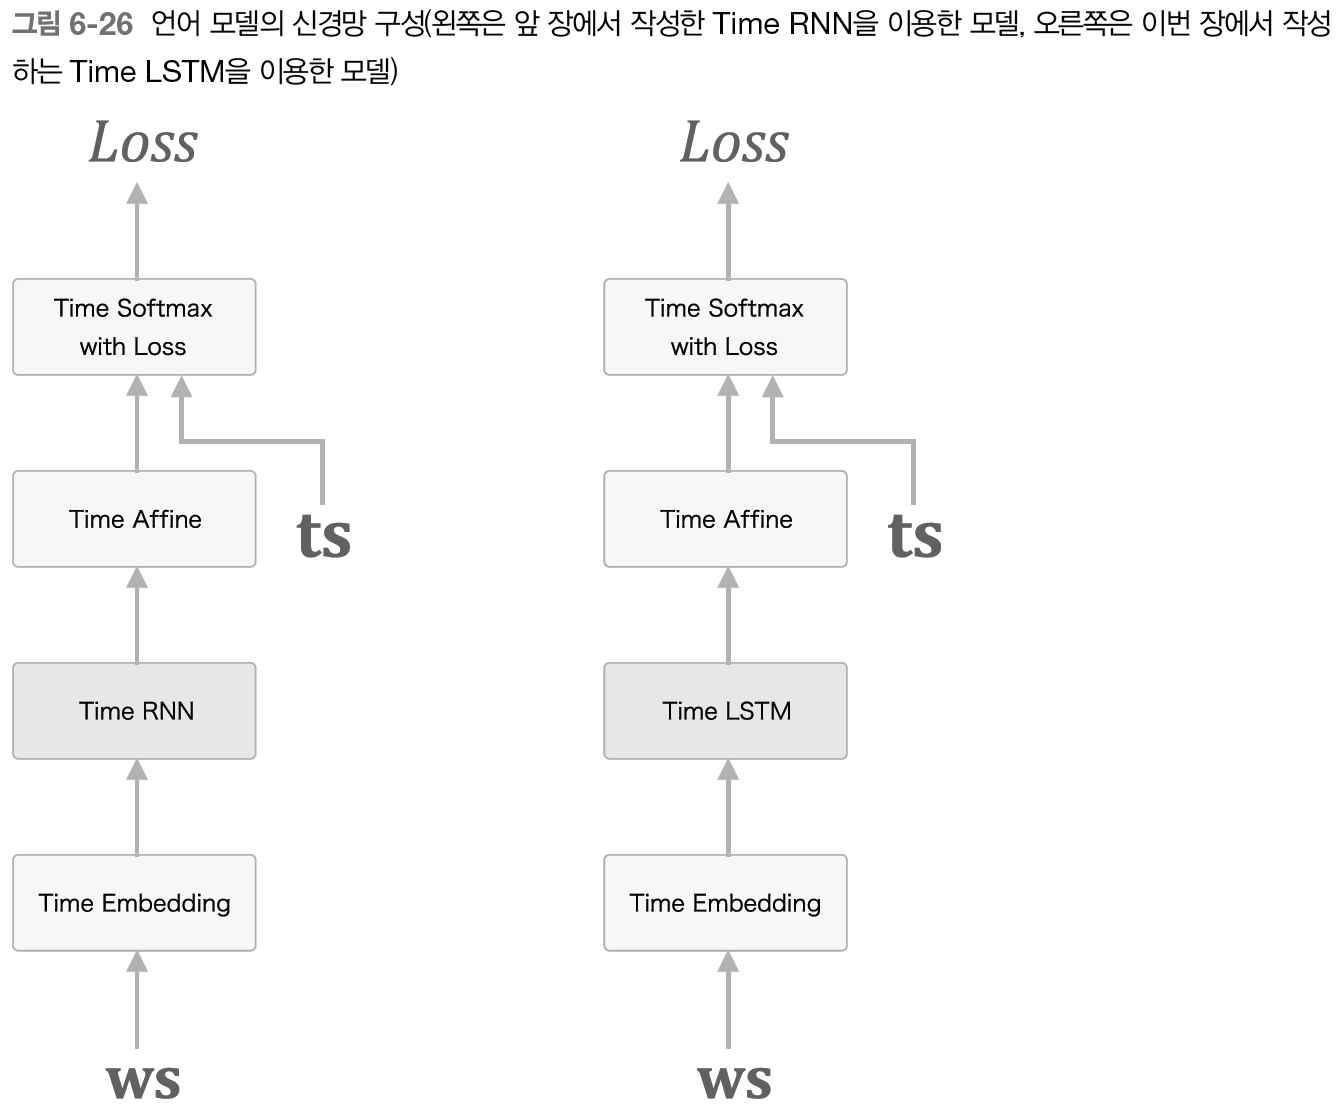

In [16]:
class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b),
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다. 
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads 
        
    def predict(self, xs): # 새로 추가되었다. Softmax 계층 직전까지를 처리한다. 7장 문장생성에서 활용된다. 
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout =1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
    
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

In [21]:
# Hyperparameter 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수 
time_size = 35 # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train') # corpus: training set
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1] 
ts = corpus[1:] # 정답레이블. Training set에서 t까지의 데이터로 t+1을 예측하는 것이니까. 

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

### 1. 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)

C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jaepil\Ana

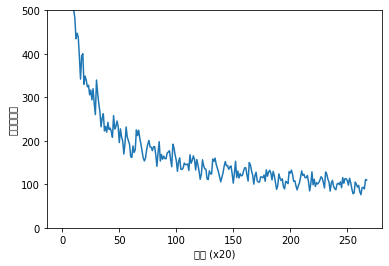

퍼플렉서티 평가 중 ...
234 / 235
Test perplexity:  135.4980777983639


In [22]:
trainer.plot(ylim=(0, 500))
###

### 2. 텍스트 데이터로 평가
model.reset_state() # 은닉상태와 기억 cell을 재설정한다는 점에 주의하자. 
ppl_test = eval_perplexity(model, corpus_test)
print('Test perplexity: ', ppl_test)
###

### 3. 매개변수 저장
# model.save_params()
###

Perplexity가 136정도 나왔다는 뜻은 우리의 모델이 다음에 나올 단어를 10000개에서 136개 정도로 줄였다는 뜻이다. 

하지만 최신 연구에서는 60을 밑돈다. 따라서 더욱 개선할 수 있다.

## 6.5 RNNLM 추가 개선

### 6.5.1 LSTM 계층 다층화

LSTM layer를 수직방향으로 하나 더 쌓을 수 있다. 몇 층을 쌓을지는 하이퍼파라미터의 문제다. PTB 언어모델에서는 2~4층 정도일 때 좋은 결과가 나온다. 

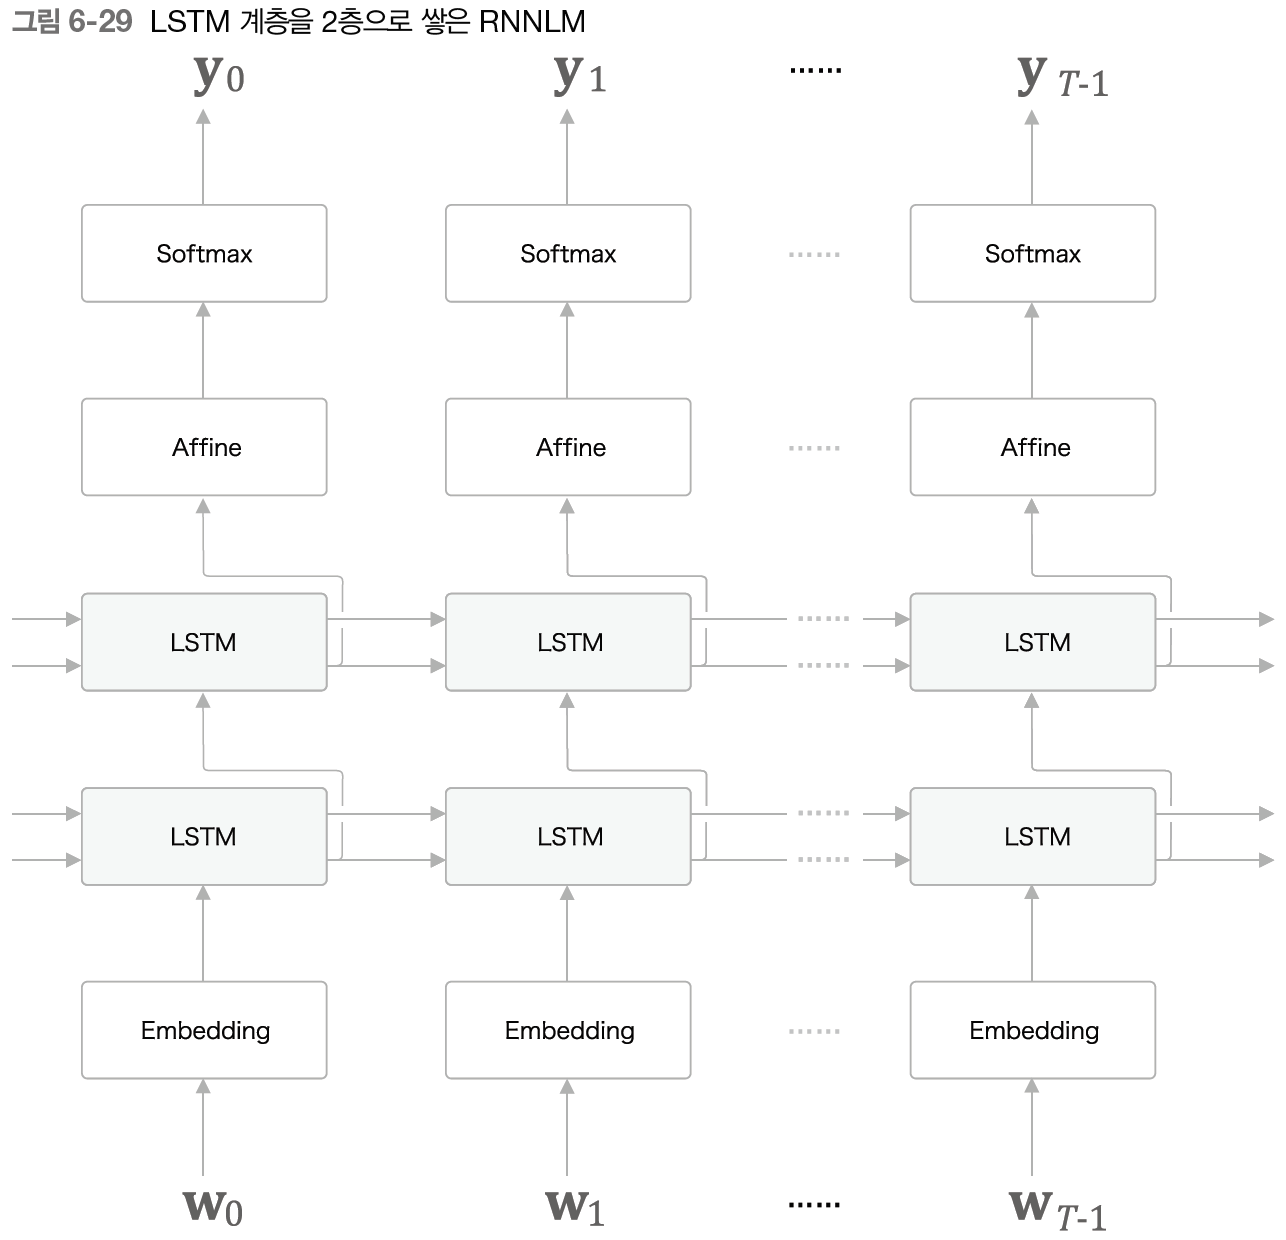



### 6.5.2 드롭아웃에 의한 과적합 억제

그런데 RNN 모델 층을 더 많이 쌓으면 과적합 문제가 발생할 수 있다. 특히 RNN은 일반적인 feed-forward보다 쉽게 과적합된다. RNN 과적합 해소는 현재도 연구되는 주제이다. 

기본적으로 
- 훈련 데이터의 양을 늘린다
- 모델의 복잡도를 줄인다
    - normalization으로 모델 복잡화에 패널티를 주는 방법
    - L2 norm 정규화
    - Dropout도 정규화의 일종이라 할 수 있다. 

드롭아웃을 해보겠다. 

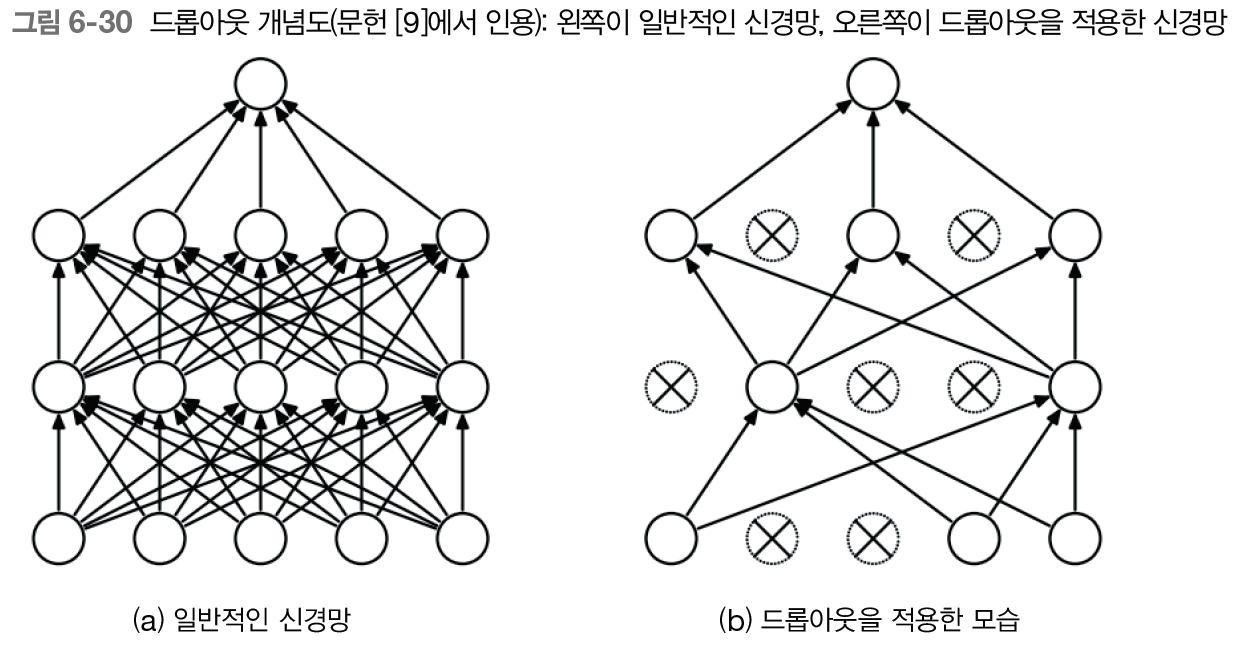

1권에서 CNN을 배울 때, 다음과 같이 dropout 계층을 삽입했었다. 

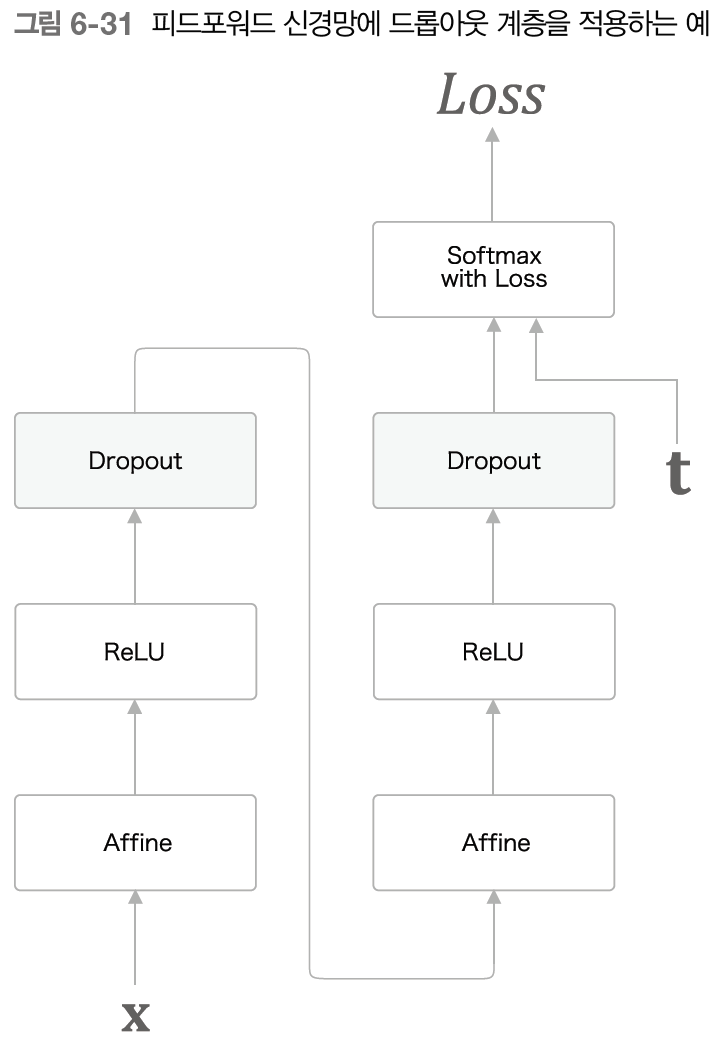

RNN에서 시계열방향(수평방향)으로 dropout을 삽입하는 것은 좋지 않다. 그러면 시간의 흐름에 따라 정보가 사라질 수 있다. 즉, 흐르는 시간에 비례해 (한 번에 학습되는 시계열 데이터의 양 `T`에 비례해) 드롭아웃 노이즈가 축적된다. 

따라서 CNN에서 한 것처럼 수직방향으로 삽입해줘야 한다. 

결론적으로 일반적으로는 드롭아웃을 수평방향으로 넣지 않는 것이 좋다고 할 수 있다. 

그러나 참고로 최신 연구에선 시간 방향으로 정규화하는 방법이 제안되고 있다. Variational Dropout의 경우 이를 성공했다. 

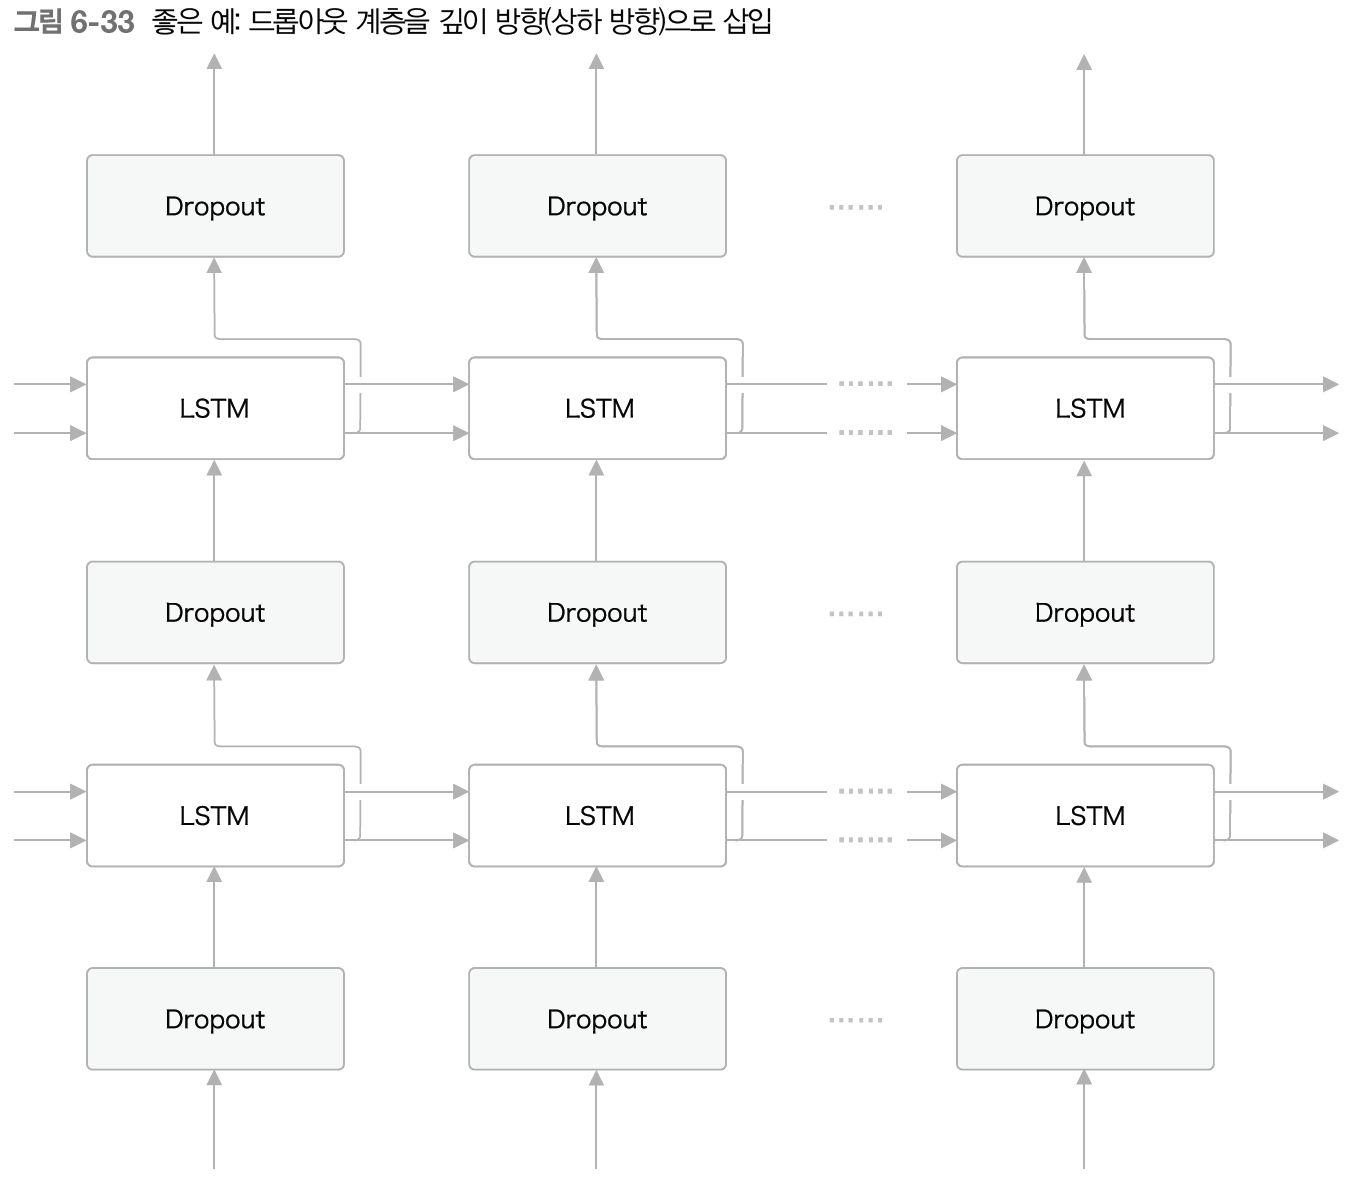



### 6.5.3 가중치 공유 (Weight Tying)

그림에서 보듯 Affine과 Embedding이 가중치를 공유한다. 가중치를 공유하면 학습하는 parameter 수가 크게 줄어드는 동시에 정확도도 향상된다. 자세한 내용은 논문 참조. 

어휘수가 `V`, LSTM의 은닉상태 차원 수가 `H`일 때, Embedding layer의 `W`는 shape가 `V` * `H`이며, Affine layer는 `W`의 shape가 `H` * `V`가 된다. 

이 때 가중치를 공유하기 위해선 Embedding layer의 `W`를 Transpose해주기만 하면 된다. 

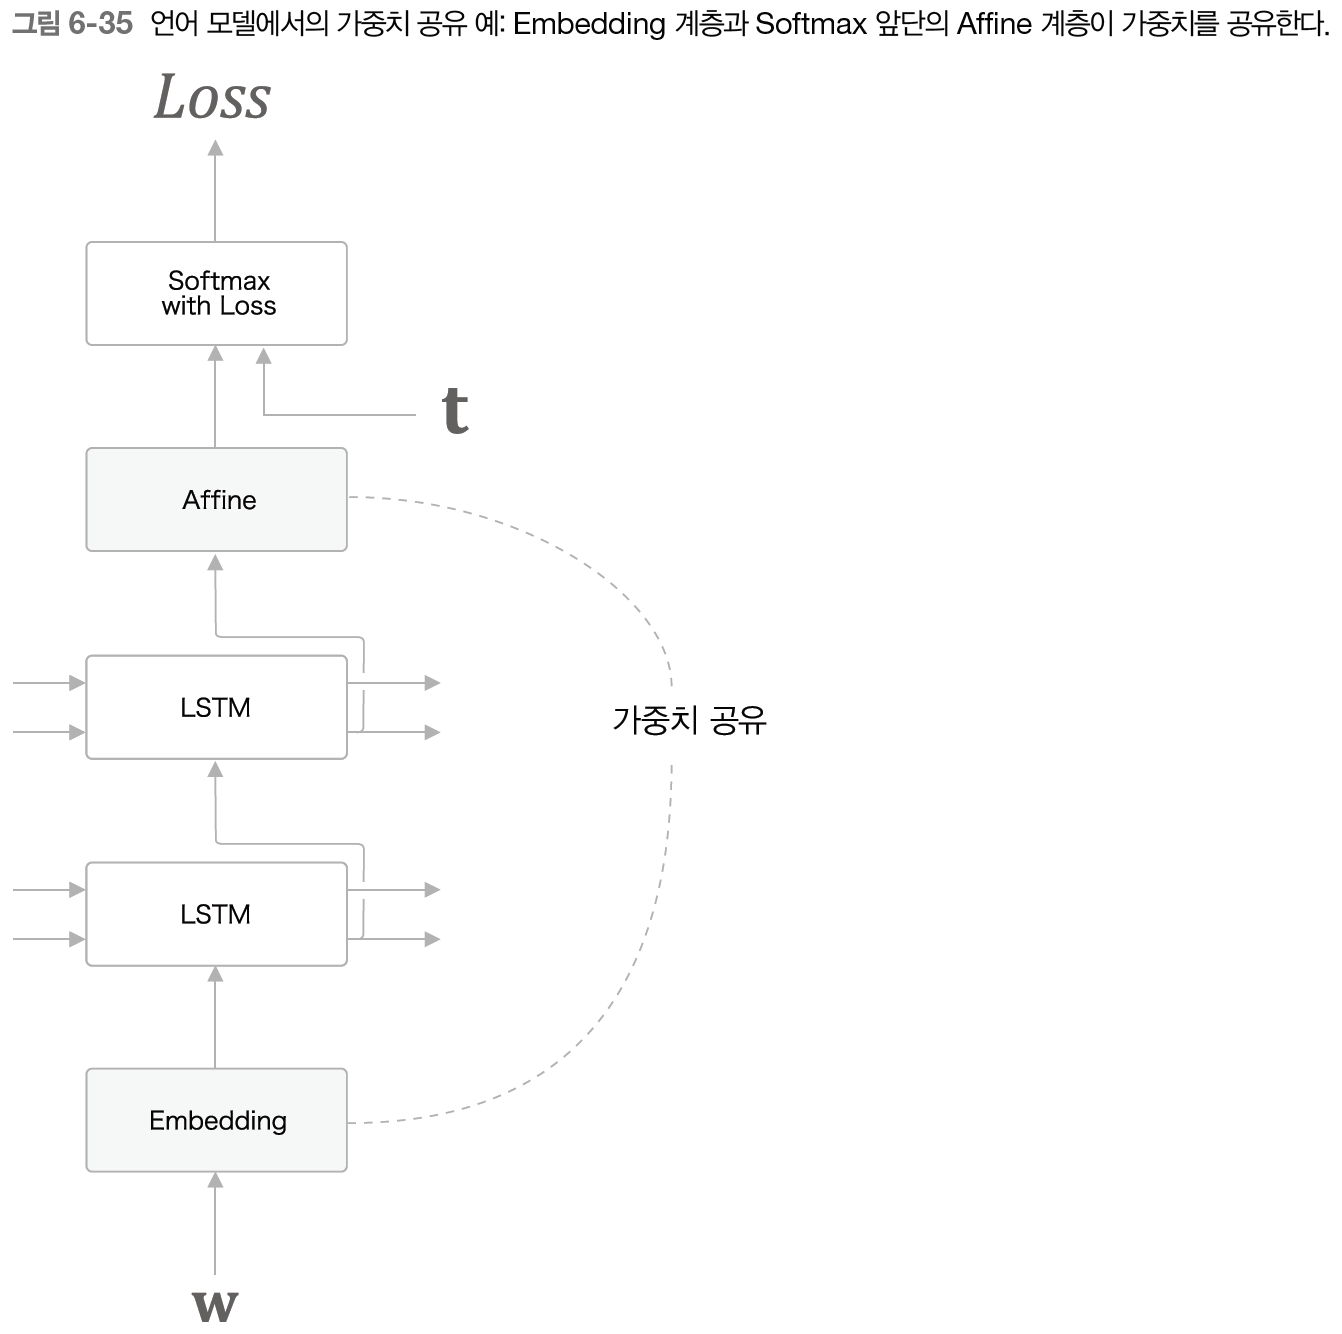

### 6.5.4 개선된 RNNLM 구현

개선점을 반영한 `BetterRnnlm`을 구현한다. 
- LSTM 계층의 다층화 (여기서는 2층)
- 드롭아웃 사용 (수직방향)
- 가중치 공유 (Embedding과 Affine layer) 

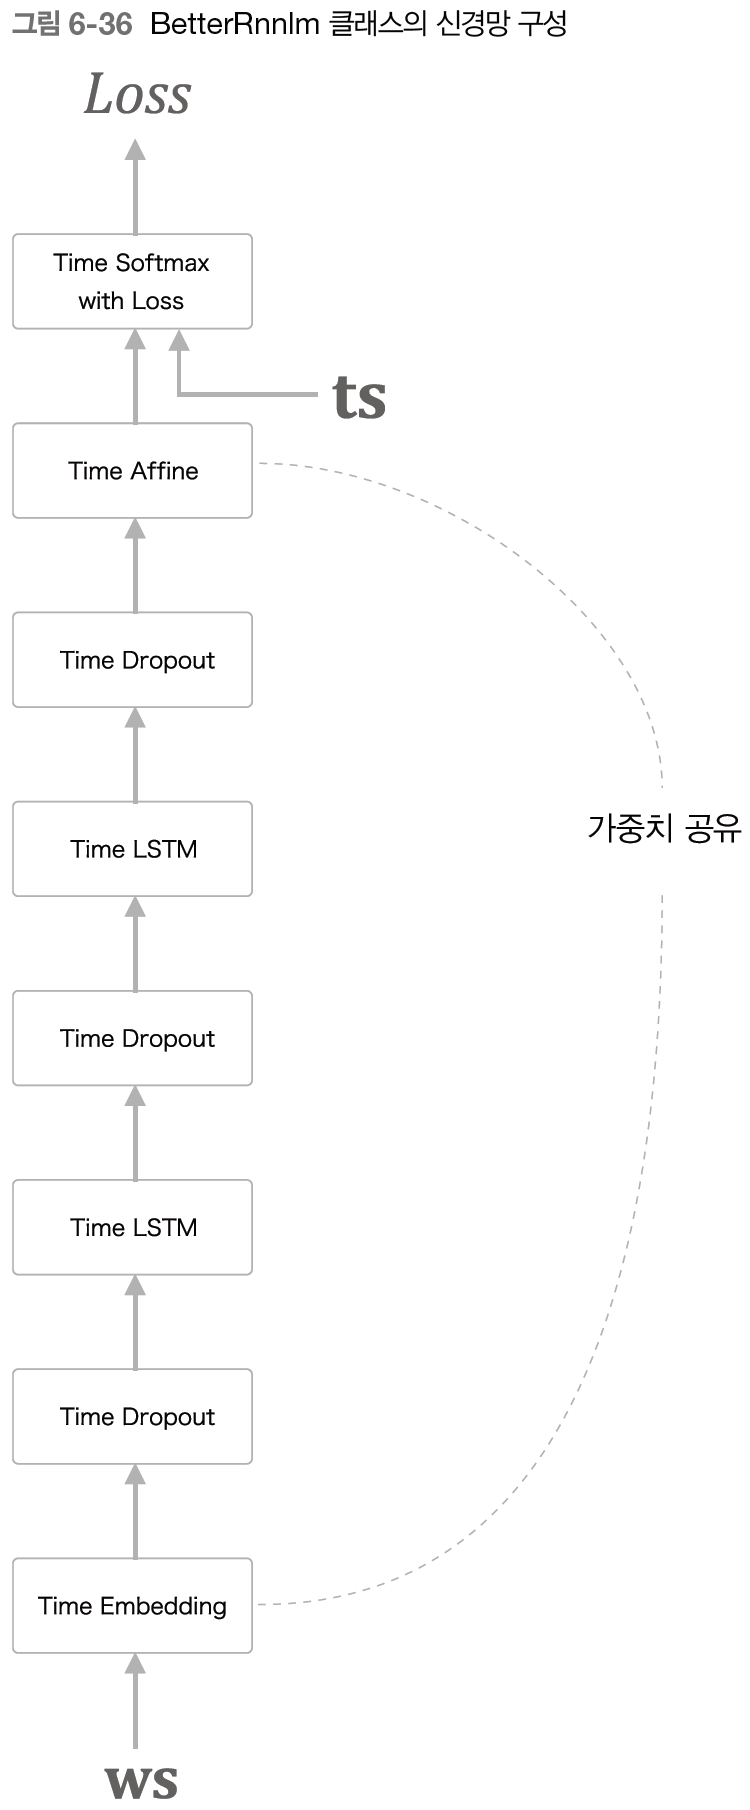

In [24]:
class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstim_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstim_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstim_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 3가지 개선
        self.layers = [
            TimeEmbedding(embed_W), 
            TimeDropout(dropout_ratio), # 중간중간 dropout 넣어준다. 수직방향으로.
            TimeLSTM(lstim_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True), # LSTM 2층
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b) # Affine의 W를 Transpose한 것을 쓴다. 가중치 공유.
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()


여기에 한 가지 개선점을 더하겠다. 

매 epoch에서 test set으로 perplexity를 평가하고, 결과가 더 안좋아졌을 때만 learning rate를 낮추는 것이다. 

실전에서 자주 쓰이는 기법이며, 보통 더 좋은 결과로 이어진다. 

거의 local minimum에 다달았을 때 learning_rate가 커서 튀기면 성능이 더 안좋게 나올테니 이럴 때 learning rate를 줄여서 더 천천히 골짜기에 들어가게 만든다는 발상 같다. 하이퍼파라미터를 어느 정도 자동으로 튜닝할 수 있는 방법인 듯. 

아래 코드는 학습에 매우 긴 시간이 소요되므로 실행하진 않는다. 

결과는 약 75.76이 나온다. 처음의 136에서 크게 개선되었다. 

학습된 가중치는 여기에서 다운로드한다: https://www.oreilly.co.jp/pub/9784873118369/BetterRnnlm.pkl

In [ ]:
# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

### 6.5.5 첨단 연구로

첨단 모델은 50 정도의 수치를 달성한다. 하지만 기본적인 idea는 지금 구현한 모델과 크게 다르지 않다. 가장 좋았던 모델은 8장에서 배우는 Attention을 사용했다. 

## 6.6 정리

- 단순한 RNN의 학습에서는 기울기 소실과 기울기 폭발이 문제가 된다. 
- 기울기 폭발에는 기울기 클리핑, 기울기 소실에는 게이트가 추가된 RNN(LSTM과 GRU 등)이 효과적이다. 
- LSTM에는 input 게이트, forget 게이트, output 게이트 등 3개의 게이트가 있다. 
- 게이트에는 전용 가중치가 있으며, 시그모이드 함수를 사용하여 0.0 ~ 1.0 사이의 실수를 출력한다. 
- 언어 모델 개선에는 LSTM 계층 다층화, 드롭아웃, 가중치 공유 등의 기법이 효과적이다. 
- RNN의 정규화는 중요한 주제이며, 드롭아웃 기반의 다양한 기법이 제안되고 있다. 